## Configuration

In [5]:
import tensorflow as tf
import numpy as np
from sklearn import linear_model
from random import shuffle
from math import floor
from sklearn.linear_model import LogisticRegression
import pickle

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(14,8)


n_samples = 747
n_features = 25
n_experiments = 5

# Hidden Layers
n_hidden_layers = 4
n_hidden_layer_size = 200

# Learning
train_portion = 0.8
n_train = floor(n_samples * train_portion)
n_test = n_samples - n_train
batch_size = 128
n_repetitions = 1000

# Other
log_level = 100

# Dropout (for NN4 Dropout)
dropout_keep_input = 0.8
dropout_keep_hidden = 0.8

## Helper Functions

In [6]:
def entropy(p):
    p = np.array(p)
    return -p * np.log(p) - (1.0-p) * np.log(1.0-p)

def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

def init_weights_xavier(shape):
    initializer = tf.contrib.layers.xavier_initializer_conv2d()
    return tf.Variable(initializer(shape=shape))

def compute_PEHE(TE_true, TE_predict):
    return np.sqrt(np.mean(np.abs(TE_true-TE_predict)**2))

def estimate_propensities(Dataset):
    X_train = Dataset.drop(['Treatment','Response','TE'],axis=1)
    y_train = Dataset['Treatment']
    logmodel     = LogisticRegression()
    logmodel.fit(X_train,y_train)
    PScores      = logmodel.predict_proba(X_train)
    Propensities = np.transpose(PScores)[1,]
    Dataset['Propensity'] = Propensities
    Dataset['Entropy']    = -Propensities*np.log(Propensities)-(1-Propensities)*np.log(1-Propensities)
    return Dataset

def parse_result_list(result_list, exp_name):
    avg_pehe_train = np.mean([np.min(res['pehe_train_vals']) for res in result_list])
    std_pehe_train = np.std([np.min(res['pehe_train_vals']) for res in result_list])
    avg_pehe_test = np.mean([np.min(res['pehe_test_vals']) for res in result_list])
    std_pehe_test = np.std([np.min(res['pehe_test_vals']) for res in result_list])

    print("{}:".format(exp_name))
    print("\t Train: Mean={0:.5f}, Std={1:.5f})\t\tTest: Mean={2:.5f} Std={3:.5f}".format(avg_pehe_train, std_pehe_train, avg_pehe_test, std_pehe_test))

## Generate IHDP Dataset

In [7]:
import pandas as pd
import numpy as np

def Draw_IHDP():
    Raw_Data = pd.read_csv('ihdp_sample.csv')
    X        = np.array(Raw_Data[['X5','X6','X7','X8','X9','X10','X11','X12','X13','X14','X15','X16','X17','X18','X19','X20','X21','X22','X23','X24','X25','X26','X27','X28','X29']])
    W        = np.array(Raw_Data['Treatment'])
    BetaB    = np.random.choice([0, 0.1, 0.2, 0.3, 0.4],size=25,replace=True,p=[0.6, 0.1, 0.1, 0.1,0.1])
    Y_0      = np.random.normal(size=len(X)) + np.exp(np.dot(X+0.5,BetaB))
    Y_1      = np.random.normal(size=len(X)) + np.dot(X,BetaB)
    AVG      = np.mean(Y_1[W==1]-Y_0[W==1])
    Y_1      = Y_1-AVG+4  
    TE       = np.dot(X,BetaB)-AVG+4-np.exp(np.dot(X+0.5,BetaB))
    Y        = np.transpose(np.array([W,(1-W)*Y_0+W*Y_1,TE]))
    DatasetX = pd.DataFrame(X,columns='X1 X2 X3 X4 X5 X6 X7 X8 X9 X10 X11 X12 X13 X14 X15 X16 X17 X18 X19 X20 X21 X22 X23 X24 X25'.split())
    DatasetY = pd.DataFrame(Y,columns='Treatment Response TE'.split())
    Dataset  = DatasetX.join(DatasetY)                        
    return Dataset

## Define Models

### NN-4 Dropout (Treatment as Feature)

In [8]:
def NN_4(X, w_h1, w_h2, w_h3, w_h4, w_o, p_keep_input, p_keep_hidden):
    X = tf.nn.dropout(X, p_keep_input)
    
    # 1st hidden layer
    h1 = tf.nn.relu(tf.matmul(X, w_h1))
    h1 = tf.nn.dropout(h1, p_keep_hidden)
    
    # 2nd hidden layer
    h2 = tf.nn.relu(tf.matmul(h1, w_h2))
    h2 = tf.nn.dropout(h2, p_keep_hidden)
    
    # 3rd hidden layer
    h3 = tf.nn.relu(tf.matmul(h2, w_h3))
    h3 = tf.nn.dropout(h3, p_keep_hidden)
    
    # 4th hidden layer
    h4 = tf.nn.relu(tf.matmul(h3, w_h4))
    h4 = tf.nn.dropout(h4, p_keep_hidden)
    
    # Output
    y_out = tf.nn.relu(tf.matmul(h4, w_o))
    return y_out

In [9]:
def run_nn4(dataset_train, dataset_test, no_dropout=False, show_log=False):

    # Define Placeholders and Init Weights
    nn4_X = tf.placeholder("float", [None, n_features + 1])
    nn4_Y = tf.placeholder("float", [None, 1])
    
    nn4_p_keep_input = tf.placeholder("float")
    nn4_p_keep_hidden = tf.placeholder("float")

    nn4_w_h1 = init_weights([n_features + 1, n_hidden_layer_size])
    nn4_w_h2 = init_weights([n_hidden_layer_size, n_hidden_layer_size])
    nn4_w_h3 = init_weights([n_hidden_layer_size, n_hidden_layer_size])
    nn4_w_h4 = init_weights([n_hidden_layer_size, n_hidden_layer_size])
    nn4_w_o = init_weights([n_hidden_layer_size, 1])

    nn4_pred = NN_4(nn4_X, nn4_w_h1, nn4_w_h2, nn4_w_h3, nn4_w_h4, nn4_w_o, nn4_p_keep_input, nn4_p_keep_hidden)
    nn4_costs = tf.reduce_mean(tf.square(nn4_pred - nn4_Y))
    nn4_train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(nn4_costs)
    
    nn4_X_train = dataset_train.drop(['Response', 'TE', 'Propensity', 'Entropy'], axis=1).as_matrix() # including treatment
    nn4_X_0_train = dataset_train.drop(['Response', 'TE', 'Treatment', 'Propensity', 'Entropy'], axis=1)
    nn4_X_0_train['Treatment'] = 0.0
    nn4_X_1_train = dataset_train.drop(['Response', 'TE', 'Treatment', 'Propensity', 'Entropy'], axis=1)
    nn4_X_1_train['Treatment'] = 1.0

    nn4_X_test = dataset_test.drop(['Response', 'TE', 'Propensity', 'Entropy'], axis=1).as_matrix() # including treatment
    nn4_X_0_test = dataset_test.drop(['Response', 'TE', 'Treatment', 'Propensity', 'Entropy'], axis=1)
    nn4_X_0_test['Treatment'] = 0.0
    nn4_X_1_test = dataset_test.drop(['Response', 'TE', 'Treatment', 'Propensity', 'Entropy'], axis=1)
    nn4_X_1_test['Treatment'] = 1.0

    TE_train = np.reshape(dataset_train['TE'].as_matrix(), [n_train, 1])
    TE_test = np.reshape(dataset_test['TE'].as_matrix(), [n_test, 1])
    
    Y_train = np.reshape(dataset_train['Response'].as_matrix(), [n_train, 1])
    Y_test = np.reshape(dataset_test['Response'].as_matrix(), [n_test, 1])

    nn_dropout_keep_hidden = dropout_keep_hidden
    nn_dropout_keep_input = dropout_keep_input

    # Parse Dropout Flag
    if no_dropout:
        nn_dropout_keep_hidden = 1.0
        nn_dropout_keep_input = 1.0
        
    
    # Start Training
    nn4_mses_train = []
    nn4_pehe_train = []
    nn4_pehe_test = []
    with tf.Session() as sess:
        tf.global_variables_initializer().run()

        for i in range(n_repetitions):

            # Training
            for start, end in zip(range(0, len(nn4_X_train), batch_size), range(batch_size, len(nn4_X_train)+1, batch_size)):            
                sess.run(nn4_train_op, feed_dict={nn4_X: nn4_X_train[start:end], 
                                              nn4_Y: Y_train[start:end],
                                              nn4_p_keep_input: nn_dropout_keep_input,
                                              nn4_p_keep_hidden: nn_dropout_keep_hidden})

            # Compute Training Error
            mse_train = sess.run(nn4_costs, feed_dict={nn4_X: nn4_X_train, nn4_Y: Y_train, nn4_p_keep_input: 1.0,  nn4_p_keep_hidden: 1.0})
            nn4_mses_train.append(mse_train)

            # Predict TE 
            # ... on training
            Y0_predict_train = sess.run(nn4_pred, feed_dict={nn4_X: nn4_X_0_train, nn4_Y: Y_train,
                                                             nn4_p_keep_input: 1.0,  nn4_p_keep_hidden: 1.0})
            Y1_predict_train = sess.run(nn4_pred, feed_dict={nn4_X: nn4_X_1_train, nn4_Y: Y_train,
                                                             nn4_p_keep_input: 1.0,  nn4_p_keep_hidden: 1.0})

            # ... on test
            Y0_predict_test = sess.run(nn4_pred, feed_dict={nn4_X: nn4_X_0_test, nn4_Y: Y_test,
                                                            nn4_p_keep_input: 1.0,  nn4_p_keep_hidden: 1.0})
            Y1_predict_test = sess.run(nn4_pred, feed_dict={nn4_X: nn4_X_1_test, nn4_Y: Y_test,
                                                            nn4_p_keep_input: 1.0,  nn4_p_keep_hidden: 1.0})


            TE_true_train              = TE_train
            TE_predict_train           = np.array(Y1_predict_train)-np.array(Y0_predict_train)

            TE_true_test               = TE_test
            TE_predict_test            = np.array(Y1_predict_test)-np.array(Y0_predict_test)

            # Compute PEHE
            pehe_train = compute_PEHE(TE_true_train, TE_predict_train)
            nn4_pehe_train.append(pehe_train)

            pehe_test = compute_PEHE(TE_true_test, TE_predict_test)
            nn4_pehe_test.append(pehe_test)


            if show_log and i % log_level == 0:
                print('#{}. \tMSE (Train): {}\t PEHE (Train): {}\t PEHE (Test): {}'.format(i, mse_train, pehe_train, pehe_test))
    
    result_dict = {
        "pehe_train_vals": nn4_pehe_train,
        "pehe_test_vals": nn4_pehe_test
    }
    
    return result_dict

### NN-4 Dropout (with 2 outputs)

In [36]:
def NN_4_multi_4s(X, w_h1, w_h2, w_h3, w_h4, w_out_0, w_out_1, p_keep_input, p_keep_hidden):
    X = tf.nn.dropout(X, p_keep_input)
    
    # 1st hidden layer (Shared)
    h1 = tf.nn.relu(tf.matmul(X, w_h1))
    h1 = tf.nn.dropout(h1, p_keep_hidden)
    
    # 2nd hidden layer (Shared)
    h2 = tf.nn.relu(tf.matmul(h1, w_h2))
    h2 = tf.nn.dropout(h2, p_keep_hidden)
    
    # 3rd hidden layer (Shared)
    h3 = tf.nn.relu(tf.matmul(h2, w_h3))
    h3 = tf.nn.dropout(h3, p_keep_hidden)
    
    # 4th hidden layer (Shared)
    h4 = tf.nn.relu(tf.matmul(h3, w_h4))
    h4 = tf.nn.dropout(h4, p_keep_hidden)
    
    # Output
    Y_0_out = tf.matmul(h4, w_out_0) 
    Y_1_out = tf.matmul(h4, w_out_1)
    
    return Y_0_out, Y_1_out

def NN_4_multi_2s_2i(X, w_h1, w_h2, w_h3, w_h4, w_out_0, w_out_1, p_keep_input, p_keep_hidden):
    X = tf.nn.dropout(X, p_keep_input)
    
    # 1st hidden layer (Shared)
    h1 = tf.nn.relu(tf.matmul(X, w_h1))
    h1 = tf.nn.dropout(h1, p_keep_hidden)
    
    # 2nd hidden layer (Shared)
    h2 = tf.nn.relu(tf.matmul(h1, w_h2))
    h2 = tf.nn.dropout(h2, p_keep_hidden)
    
    # 3rd hidden layer (idiosyncratic for Y0)
    h3 = tf.nn.relu(tf.matmul(h2, w_h3))
    h3 = tf.nn.dropout(h3, p_keep_hidden)
    
    # 4th hidden layer (idiosyncratic for Y1)
    h4 = tf.nn.relu(tf.matmul(h2, w_h4))
    h4 = tf.nn.dropout(h4, p_keep_hidden)
    
    # Output
    Y_0_out = tf.matmul(h3, w_out_0) 
    Y_1_out = tf.matmul(h4, w_out_1)
    
    return Y_0_out, Y_1_out

def NN_4_multi_2s_4i(X, w_h1, w_h2, w_h3, w_h3_2, w_h4, w_h4_2, w_out_0, w_out_1, p_keep_input, p_keep_hidden):
    X = tf.nn.dropout(X, p_keep_input)
    
    # 1st hidden layer (Shared)
    h1 = tf.nn.relu(tf.matmul(X, w_h1))
    h1 = tf.nn.dropout(h1, p_keep_hidden)
    
    # 2nd hidden layer (Shared)
    h2 = tf.nn.relu(tf.matmul(h1, w_h2))
    h2 = tf.nn.dropout(h2, p_keep_hidden)
    
    # 3rd hidden layer  (idiosyncratic for Y0) -- 1
    h3 = tf.nn.relu(tf.matmul(h2, w_h3))
    h3 = tf.nn.dropout(h3, p_keep_hidden)
    
    # 3rd hidden layer (idiosyncratic for Y0)  -- 2
    h3_2 = tf.nn.relu(tf.matmul(h3, w_h3_2))
    h3_2 = tf.nn.dropout(h3_2, p_keep_hidden)
    
    # 4th hidden layer (idiosyncratic for Y1) -- 1
    h4 = tf.nn.relu(tf.matmul(h2, w_h4))
    h4 = tf.nn.dropout(h4, p_keep_hidden)
    
    # 4th hidden layer (idiosyncratic for Y1) -- 2
    h4_2 = tf.nn.relu(tf.matmul(h4, w_h4_2))
    h4_2 = tf.nn.dropout(h4_2, p_keep_hidden)
    
    
    # Output
    Y_0_out = tf.matmul(h3_2, w_out_0) 
    Y_1_out = tf.matmul(h4_2, w_out_1)
    
    return Y_0_out, Y_1_out

In [37]:
def run_nn4_dropout(dataset_train, dataset_test, no_dropout=False, show_log=False, architecture='4s'):
    
    # Define Placeholders and Init Weights
    nn4_dropout_X = tf.placeholder("float", [None, n_features])
    nn4_dropout_Y = tf.placeholder("float", [None, 1])

    nn4_dropout_p_keep_input = tf.placeholder("float")
    nn4_dropout_p_keep_hidden = tf.placeholder("float")

    nn4_dropout_Y_0         = tf.placeholder("float", shape=[None, 1])       # Task 1 output
    nn4_dropout_Y_1         = tf.placeholder("float", shape=[None, 1])       # Task 2 output

    nn4_dropout_w_h1 = init_weights_xavier([n_features, n_hidden_layer_size])
    nn4_dropout_w_h2 = init_weights_xavier([n_hidden_layer_size, n_hidden_layer_size])
    nn4_dropout_w_h3 = init_weights_xavier([n_hidden_layer_size, n_hidden_layer_size])
    nn4_dropout_w_h3_2 = init_weights_xavier([n_hidden_layer_size, n_hidden_layer_size])
    nn4_dropout_w_h4 = init_weights_xavier([n_hidden_layer_size, n_hidden_layer_size])
    nn4_dropout_w_h4_2 = init_weights_xavier([n_hidden_layer_size, n_hidden_layer_size])
    nn4_dropout_w_out_0 = init_weights_xavier([n_hidden_layer_size, 1])
    nn4_dropout_w_out_1 = init_weights_xavier([n_hidden_layer_size, 1])

    # Parse Shared Layers Flag
    if architecture == '4s':
        nn4_dropout_pred_Y0, nn4_dropout_pred_Y1 = NN_4_multi_4s(nn4_dropout_X, nn4_dropout_w_h1, nn4_dropout_w_h2, nn4_dropout_w_h3, 
            nn4_dropout_w_h4, nn4_dropout_w_out_0, nn4_dropout_w_out_1, nn4_dropout_p_keep_input, nn4_dropout_p_keep_hidden)
    elif architecture == '4s_2i':
        nn4_dropout_pred_Y0, nn4_dropout_pred_Y1 = NN_4_multi_2s_2i(nn4_dropout_X, nn4_dropout_w_h1, nn4_dropout_w_h2, nn4_dropout_w_h3, 
            nn4_dropout_w_h4, nn4_dropout_w_out_0, nn4_dropout_w_out_1, nn4_dropout_p_keep_input, nn4_dropout_p_keep_hidden) 
    elif architecture == '4s_4i':
        nn4_dropout_pred_Y0, nn4_dropout_pred_Y1 = NN_4_multi_2s_4i(nn4_dropout_X, nn4_dropout_w_h1, nn4_dropout_w_h2, nn4_dropout_w_h3, 
            nn4_dropout_w_h3_2, nn4_dropout_w_h4, nn4_dropout_w_h4_2, nn4_dropout_w_out_0, nn4_dropout_w_out_1, nn4_dropout_p_keep_input, nn4_dropout_p_keep_hidden) 
    else: 
        raise Exception('Invalid architecture passed ({})'.format(architecture))

    nn4_dropout_cost0     = tf.nn.l2_loss(nn4_dropout_Y_0-nn4_dropout_pred_Y0)
    nn4_dropout_cost1     = tf.nn.l2_loss(nn4_dropout_Y_1-nn4_dropout_pred_Y1)

    nn4_dropout_optim0    = tf.train.AdamOptimizer(learning_rate=0.001).minimize(nn4_dropout_cost0)
    nn4_dropout_optim1    = tf.train.AdamOptimizer(learning_rate=0.001).minimize(nn4_dropout_cost1)
    
    nn4_dropout_X_train = dataset_train.drop(['Response', 'TE', 'Treatment', 'Propensity', 'Entropy'], axis=1).as_matrix() 
    TE_train = np.reshape(dataset_train['TE'].as_matrix(), [n_train, 1])

    nn4_dropout_X_test = dataset_test.drop(['Response', 'TE', 'Treatment', 'Propensity', 'Entropy'], axis=1).as_matrix() 
    TE_test = np.reshape(dataset_test['TE'].as_matrix(), [n_test, 1])

    nn_dropout_keep_hidden = dropout_keep_hidden
    nn_dropout_keep_input = dropout_keep_input
    
    Y_train = np.reshape(dataset_train['Response'].as_matrix(), [n_train, 1])
    Y_test = np.reshape(dataset_test['Response'].as_matrix(), [n_test, 1])
    
    # Parse Dropout Flag
    if no_dropout:
        nn_dropout_keep_hidden = 1.0
        nn_dropout_keep_input = 1.0
        
    
    # Start Training
    nn4_dropout_mses_train_0 = []
    nn4_dropout_mses_train_1 = []

    nn4_dropout_pehe_train = []
    nn4_dropout_pehe_test = []

    Y0_loss = 0
    Y1_loss = 0
    with tf.Session() as sess:
        tf.global_variables_initializer().run()

        for i in range(n_repetitions):
            if i%2 == 0:
                _, Y0_loss = sess.run([nn4_dropout_optim0, nn4_dropout_cost0], feed_dict= {
                              nn4_dropout_X  : nn4_dropout_X_train[dataset_train['Treatment']==0], 
                              nn4_dropout_Y_0: Y_train[dataset_train['Treatment']==0],
                              nn4_dropout_p_keep_input: nn_dropout_keep_input,
                              nn4_dropout_p_keep_hidden: nn_dropout_keep_hidden})
            else:
                _, Y1_loss = sess.run([nn4_dropout_optim1, nn4_dropout_cost1], feed_dict= {
                              nn4_dropout_X  : nn4_dropout_X_train[dataset_train['Treatment']==1], 
                              nn4_dropout_Y_1: Y_train[dataset_train['Treatment']==1],
                              nn4_dropout_p_keep_input: nn_dropout_keep_input,
                              nn4_dropout_p_keep_hidden: nn_dropout_keep_hidden})

            # Compute Training Error
            nn4_dropout_mses_train_0.append(Y0_loss)
            nn4_dropout_mses_train_1.append(Y1_loss)


            # Predict TE
            Y0_predict_train = sess.run(nn4_dropout_pred_Y0, feed_dict={nn4_dropout_X: nn4_dropout_X_train, nn4_dropout_p_keep_input: 1.0,
                              nn4_dropout_p_keep_hidden: 1.0})
            Y1_predict_train = sess.run(nn4_dropout_pred_Y1, feed_dict={nn4_dropout_X: nn4_dropout_X_train, nn4_dropout_p_keep_input: 1.0,
                              nn4_dropout_p_keep_hidden: 1.0})

            TE_true_train               = TE_train
            TE_predict_train            = np.array(Y1_predict_train)-np.array(Y0_predict_train)

            Y0_predict_test = sess.run(nn4_dropout_pred_Y0, feed_dict={nn4_dropout_X: nn4_dropout_X_test, nn4_dropout_p_keep_input: 1.0,
                              nn4_dropout_p_keep_hidden: 1.0})
            Y1_predict_test = sess.run(nn4_dropout_pred_Y1, feed_dict={nn4_dropout_X: nn4_dropout_X_test, nn4_dropout_p_keep_input: 1.0,
                              nn4_dropout_p_keep_hidden: 1.0})

            TE_true_test               = TE_test
            TE_predict_test            = np.array(Y1_predict_test)-np.array(Y0_predict_test)

            # Compute PEHE
            pehe_train = compute_PEHE(TE_true_train, TE_predict_train)
            nn4_dropout_pehe_train.append(pehe_train)

            pehe_test = compute_PEHE(TE_true_test, TE_predict_test)
            nn4_dropout_pehe_test.append(pehe_test)

            if show_log and i % log_level == 0:
                print('#{}. \tMSE Y0: {} \tMSE Y1: {}\t PEHE: {}'.format(i, Y0_loss, Y1_loss, pehe_train))

        sess.close()

    result_dict = {
        "pehe_train_vals": nn4_dropout_pehe_train,
        "pehe_test_vals": nn4_dropout_pehe_test
    }
    
    return result_dict

### NN-4 Propensity-Based Dropout

In [38]:
def NN_4_PBD(X, entropy, rand_mask_X, rand_mask_h1, rand_mask_h2, rand_mask_h3, rand_mask_h4, w_h1, w_h2, w_h3, w_h4, w_out_0, w_out_1):
    
    # Compute Keep Probability based on entropy
    keep_prop = entropy + 0.5

    # Input Layer
    pbd_mask_X = tf.to_float(tf.greater_equal(keep_prop, rand_mask_X))
    X = tf.multiply(X, pbd_mask_X)
    #w_h1_rescaled = w_h1 * (1.0/keep_prop)
    
    # 1st hidden layer (Shared)
    h1 = tf.nn.relu(tf.matmul(X, w_h1))
    pbd_mask_h1 = tf.to_float(tf.greater_equal(keep_prop, rand_mask_h1))
    #h1 = tf.multiply(h1, pbd_mask_h1)
    #w_h2_rescaled = w_h2 * (1.0/keep_prop)
    
    # 2nd hidden layer (Shared)
    h2 = tf.nn.relu(tf.matmul(h1, w_h2))
    pbd_mask_h2 = tf.to_float(tf.greater_equal(keep_prop, rand_mask_h2))
    #h2 = tf.multiply(h2, pbd_mask_h2)
    #w_h3_rescaled = w_h3 * (1.0/keep_prop)

    # 3rd hidden layer
    h3 = tf.nn.relu(tf.matmul(h2, w_h3))
    pbd_mask_h3 = tf.to_float(tf.greater_equal(keep_prop, rand_mask_h3))
    #h3 = tf.multiply(h3, pbd_mask_h3)
    #w_h4_rescaled = w_h4 * (1.0/keep_prop)

    # 4th hidden layer
    h4 = tf.nn.relu(tf.matmul(h3, w_h4))
    pbd_mask_h4 = tf.to_float(tf.greater_equal(keep_prop, rand_mask_h4))
    #h4 = tf.multiply(h4, pbd_mask_h3)
    #w_out_0_rescaled = w_out_0 * (1.0/keep_prop)
    #w_out_1_rescaled = w_out_1 * (1.0/keep_prop)
    
    # Output
    Y_0_out = tf.matmul(h4, w_out_0) 
    Y_1_out = tf.matmul(h4, w_out_1)
    
    return Y_0_out, Y_1_out

In [39]:
def run_nn4_pbd(dataset_train, dataset_test, show_log=False):
    
    # Define Placeholders and Init Weights
    nn4_pbd_X = tf.placeholder("float", [None, n_features])
    nn4_pbd_Entropy = tf.placeholder("float", [None, 1])
    #nn4_pbd_rand_mask = tf.placeholder("float", [None, n_features])
    
    nn4_pbd_rand_mask_X = tf.placeholder("float", [None, n_features])
    nn4_pbd_rand_mask_h1 = tf.placeholder("float", [None, n_hidden_layer_size])
    nn4_pbd_rand_mask_h2 = tf.placeholder("float", [None, n_hidden_layer_size])
    nn4_pbd_rand_mask_h3 = tf.placeholder("float", [None, n_hidden_layer_size])
    nn4_pbd_rand_mask_h4 = tf.placeholder("float", [None, n_hidden_layer_size])
    

    nn4_pbd_Y = tf.placeholder("float", [None, 1])

    nn4_pbd_Y_0         = tf.placeholder("float", shape=[None, 1])       # Task 1 output
    nn4_pbd_Y_1         = tf.placeholder("float", shape=[None, 1])       # Task 2 output

    nn4_pbd_w_h1 = init_weights_xavier([n_features, n_hidden_layer_size])
    nn4_pbd_w_h2 = init_weights_xavier([n_hidden_layer_size, n_hidden_layer_size])
    nn4_pbd_w_h3 = init_weights_xavier([n_hidden_layer_size, n_hidden_layer_size])
    nn4_pbd_w_h4 = init_weights_xavier([n_hidden_layer_size, n_hidden_layer_size])
    nn4_pbd_w_out_0 = init_weights_xavier([n_hidden_layer_size, 1])
    nn4_pbd_w_out_1 = init_weights_xavier([n_hidden_layer_size, 1])


    nn4_pbd_pred_Y0, nn4_pbd_pred_Y1 = NN_4_PBD(nn4_pbd_X, nn4_pbd_Entropy, nn4_pbd_rand_mask_X, nn4_pbd_rand_mask_h1, nn4_pbd_rand_mask_h2,
                                       nn4_pbd_rand_mask_h3, nn4_pbd_rand_mask_h4, nn4_pbd_w_h1, nn4_pbd_w_h2, nn4_pbd_w_h3, nn4_pbd_w_h4, 
                                       nn4_pbd_w_out_0, nn4_pbd_w_out_1)


    
    nn4_pbd_cost0     = tf.nn.l2_loss(nn4_pbd_Y_0-nn4_pbd_pred_Y0)
    nn4_pbd_cost1     = tf.nn.l2_loss(nn4_pbd_Y_1-nn4_pbd_pred_Y1)

    nn4_pbd_optim0    = tf.train.AdamOptimizer(learning_rate=0.001).minimize(nn4_pbd_cost0)
    nn4_pbd_optim1    = tf.train.AdamOptimizer(learning_rate=0.001).minimize(nn4_pbd_cost1)


    nn4_pbd_X_train = dataset_train.drop(['Response', 'TE', 'Treatment', 'Propensity', 'Entropy'], axis=1).as_matrix() 
    TE_train = np.reshape(dataset_train['TE'].as_matrix(), [n_train, 1])
    nn4_pbd_Entropy_train =  np.reshape(dataset_train['Entropy'].as_matrix(), [n_train, 1])

    nn4_pbd_X_test = dataset_test.drop(['Response', 'TE', 'Treatment', 'Propensity', 'Entropy'], axis=1).as_matrix() 
    TE_test = np.reshape(dataset_test['TE'].as_matrix(), [n_test, 1])
    nn4_pbd_Entropy_test =  np.reshape(dataset_test['Entropy'].as_matrix(), [n_test, 1])
    
    Y_train = np.reshape(dataset_train['Response'].as_matrix(), [n_train, 1])
    Y_test = np.reshape(dataset_test['Response'].as_matrix(), [n_test, 1])


    # Start Training
    nn4_pbd_mses_train_0 = []
    nn4_pbd_mses_train_1 = []

    nn4_pbd_pehe_train = []
    nn4_pbd_pehe_test = []


    Y0_loss = 0
    Y1_loss = 0
    with tf.Session() as sess:
        tf.global_variables_initializer().run()

        for i in range(n_repetitions):

            if i%2 == 0:
                n = Y_train[dataset_train['Treatment']==0].shape[0]
                _, Y0_loss = sess.run([nn4_pbd_optim0, nn4_pbd_cost0], feed_dict= {
                              nn4_pbd_X  : nn4_pbd_X_train[dataset_train['Treatment']==0], 
                              nn4_pbd_Y_0: Y_train[dataset_train['Treatment']==0], 
                              nn4_pbd_Entropy: nn4_pbd_Entropy_train[dataset_train['Treatment']==0],
                              nn4_pbd_rand_mask_X: np.random.uniform(size=[n, n_features]),
                              nn4_pbd_rand_mask_h1: np.random.uniform(size=[n, n_hidden_layer_size]),
                              nn4_pbd_rand_mask_h2: np.random.uniform(size=[n, n_hidden_layer_size]),
                              nn4_pbd_rand_mask_h3: np.random.uniform(size=[n, n_hidden_layer_size]),
                              nn4_pbd_rand_mask_h4: np.random.uniform(size=[n, n_hidden_layer_size])})
            else:
                n = Y_train[dataset_train['Treatment']==1].shape[0]
                _, Y1_loss = sess.run([nn4_pbd_optim1, nn4_pbd_cost1], feed_dict= {
                              nn4_pbd_X  : nn4_pbd_X_train[dataset_train['Treatment']==1], 
                              nn4_pbd_Y_1: Y_train[dataset_train['Treatment']==1],
                              nn4_pbd_Entropy: nn4_pbd_Entropy_train[dataset_train['Treatment']==1],
                              nn4_pbd_rand_mask_X: np.random.uniform(size=[n, n_features]),
                              nn4_pbd_rand_mask_h1: np.random.uniform(size=[n, n_hidden_layer_size]),
                              nn4_pbd_rand_mask_h2: np.random.uniform(size=[n, n_hidden_layer_size]),
                              nn4_pbd_rand_mask_h3: np.random.uniform(size=[n, n_hidden_layer_size]),
                              nn4_pbd_rand_mask_h4: np.random.uniform(size=[n, n_hidden_layer_size])})

            # Compute Training Error
            nn4_pbd_mses_train_0.append(Y0_loss)
            nn4_pbd_mses_train_1.append(Y1_loss)

            # Predict TE
            # ... on Training Set
            Y0_predict_train = sess.run(nn4_pbd_pred_Y0, feed_dict={nn4_pbd_X: nn4_pbd_X_train, 
                                                              nn4_pbd_rand_mask_X: np.ones((n_train, n_features)),
                                                              nn4_pbd_rand_mask_h1: np.ones((n_train, n_hidden_layer_size)),
                                                              nn4_pbd_rand_mask_h2: np.ones((n_train, n_hidden_layer_size)),
                                                              nn4_pbd_rand_mask_h3: np.ones((n_train, n_hidden_layer_size)),
                                                              nn4_pbd_rand_mask_h4: np.ones((n_train, n_hidden_layer_size)),
                                                              nn4_pbd_Entropy: 0.5 * np.ones((n_train, 1))
                                                             })
            Y1_predict_train = sess.run(nn4_pbd_pred_Y1, feed_dict={nn4_pbd_X: nn4_pbd_X_train, 
                                                              nn4_pbd_rand_mask_X: np.ones((n_train, n_features)),
                                                              nn4_pbd_rand_mask_h1: np.ones((n_train, n_hidden_layer_size)),
                                                              nn4_pbd_rand_mask_h2: np.ones((n_train, n_hidden_layer_size)),
                                                              nn4_pbd_rand_mask_h3: np.ones((n_train, n_hidden_layer_size)),
                                                              nn4_pbd_rand_mask_h4: np.ones((n_train, n_hidden_layer_size)),
                                                              nn4_pbd_Entropy: 0.5 * np.ones((n_train, 1))})

            TE_true_train               = TE_train
            TE_predict_train            = np.array(Y1_predict_train)-np.array(Y0_predict_train)

            # ... on Test Set
            Y0_predict_test = sess.run(nn4_pbd_pred_Y0, feed_dict={nn4_pbd_X: nn4_pbd_X_test, 
                                                              nn4_pbd_rand_mask_X: np.ones((n_test, n_features)),
                                                              nn4_pbd_rand_mask_h1: np.ones((n_test, n_hidden_layer_size)),
                                                              nn4_pbd_rand_mask_h2: np.ones((n_test, n_hidden_layer_size)),
                                                              nn4_pbd_rand_mask_h3: np.ones((n_test, n_hidden_layer_size)),
                                                              nn4_pbd_rand_mask_h4: np.ones((n_test, n_hidden_layer_size)),
                                                              nn4_pbd_Entropy: 0.5 * np.ones((n_test, 1))
                                                             })
            Y1_predict_test = sess.run(nn4_pbd_pred_Y1, feed_dict={nn4_pbd_X: nn4_pbd_X_test, 
                                                              nn4_pbd_rand_mask_X: np.ones((n_test, n_features)),
                                                              nn4_pbd_rand_mask_h1: np.ones((n_test, n_hidden_layer_size)),
                                                              nn4_pbd_rand_mask_h2: np.ones((n_test, n_hidden_layer_size)),
                                                              nn4_pbd_rand_mask_h3: np.ones((n_test, n_hidden_layer_size)),
                                                              nn4_pbd_rand_mask_h4: np.ones((n_test, n_hidden_layer_size)),
                                                              nn4_pbd_Entropy: 0.5 * np.ones((n_test, 1))})

            TE_true_test               = TE_test
            TE_predict_test            = np.array(Y1_predict_test)-np.array(Y0_predict_test)

            # Compute PEHE
            pehe_train = compute_PEHE(TE_true_train, TE_predict_train)
            nn4_pbd_pehe_train.append(pehe_train)

            pehe_test = compute_PEHE(TE_true_test, TE_predict_test)
            nn4_pbd_pehe_test.append(pehe_test)


            if show_log and i % log_level == 0:
                print('#{}. \tMSE Y0: {} \tMSE Y1: {}\t PEHE (Train): {}\t PEHE (Test): {}'.format(i, floor(Y0_loss), floor(Y1_loss), pehe_train, pehe_test))

        sess.close()
    
    result_dict = {
        "pehe_train_vals": nn4_pbd_pehe_train,
        "pehe_test_vals": nn4_pbd_pehe_test
    }
    
    return result_dict

## Run Experiments

In [40]:
nn4_all_results = []               # NN4 (Dropout)
nn4_no_dropout_all_results = []    # NN4 (no Dropout)
nn4_multi_4s_all_results = []      # NN4 2 outcomes 4 shared
nn4_multi_2s_2i_all_results = []   # NN4 2 outcomes 2 shared, 2 idiosyncratic
nn4_multi_2s_4i_all_results = []   # NN4 2 outcomes 2 shared, 2 idiosyncratic
nn4_pbd_all_results = []           # NN4 2 outcomes (PBD)

for i in range(n_experiments):
    print('Running Experiment {}/{}.'.format(i+1, n_experiments))
    
    # Draw Data
    dataset = Draw_IHDP()
    estimate_propensities(dataset)
    
    # Shuffle Dataset
    dataset = dataset.sample(frac=1).reset_index(drop=True)

    # Split Data into test and training set
    dataset_train = dataset[0:n_train]
    dataset_test = dataset[n_train:]
    
    # NN4 (Dropout)
    #nn4_results = run_nn4(dataset_train, dataset_test)
    #nn4_all_results.append(nn4_results)
    #nn4_min_pehe_train =  np.min(nn4_results['pehe_train_vals'])
    #nn4_min_pehe_test =  np.min(nn4_results['pehe_test_vals'])

    # NN4 (no Dropout)
    #nn4_no_dropout_results = run_nn4(dataset_train, dataset_test, no_dropout=True)
    #nn4_no_dropout_all_results.append(nn4_no_dropout_results)
    #nn4_no_dropout_min_pehe_train =  np.min(nn4_no_dropout_results['pehe_train_vals'])
    #nn4_no_dropout_min_pehe_test =  np.min(nn4_no_dropout_results['pehe_test_vals'])
    
    # NN4 2 outcomes 4 shared layers(Dropout)
    nn4_multi_4s_results = run_nn4_dropout(dataset_train, dataset_test, architecture='4s')
    nn4_multi_4s_all_results.append(nn4_multi_4s_results)    
    nn4_multi_4s_min_pehe_train =  np.min(nn4_multi_4s_results['pehe_train_vals'])
    nn4_multi_4s_min_pehe_test =  np.min(nn4_multi_4s_results['pehe_test_vals'])
    
    # NN4 2 outcomes 2 shared layers, 1 idiosyncratic per outcome (Dropout)
    nn4_multi_2s_2i_results = run_nn4_dropout(dataset_train, dataset_test, architecture='4s_2i')
    nn4_multi_2s_2i_all_results.append(nn4_multi_2s_2i_results)    
    nn4_multi_2s_2i_min_pehe_train =  np.min(nn4_multi_2s_2i_results['pehe_train_vals'])
    nn4_multi_2s_2i_min_pehe_test =  np.min(nn4_multi_2s_2i_results['pehe_test_vals'])
    
    # NN4 2 outcomes 2 shared layers, 2 idiosyncratic per outcome (Dropout)
    nn4_multi_2s_4i_results = run_nn4_dropout(dataset_train, dataset_test, architecture='4s_4i')
    nn4_multi_2s_4i_all_results.append(nn4_multi_2s_4i_results)    
    nn4_multi_2s_4i_min_pehe_train =  np.min(nn4_multi_2s_4i_results['pehe_train_vals'])
    nn4_multi_2s_4i_min_pehe_test =  np.min(nn4_multi_2s_4i_results['pehe_test_vals'])
    
    # NN4 2 outcomes (PBD)
    #nn4_pbd_results = run_nn4_pbd(dataset_train, dataset_test)
    #nn4_pbd_all_results.append(nn4_pbd_results)    
    #nn4_pbd_min_pehe_train =  np.min(nn4_pbd_results['pehe_train_vals'])
    #nn4_pbd_min_pehe_test =  np.min(nn4_pbd_results['pehe_test_vals'])
    

    #print('\tMin. PEHE (Train). NN4: {}\t NN4 (no Dropout): {}\t NN4 Dropout: {}\t NN4 PBD: {}'.format(nn4_min_pehe_train, nn4_no_dropout_min_pehe_train, nn4_dropout_min_pehe_train, nn4_pbd_min_pehe_train))
    #print('\tMin. PEHE (Test). NN4: {}\t NN4 (no Dropout): {}\t NN4 Dropout: {}\t NN4 PBD: {}'.format(nn4_min_pehe_test, nn4_no_dropout_min_pehe_test, nn4_dropout_min_pehe_test, nn4_pbd_min_pehe_test))
    
    # Only 2 Outcomes
    print('\tMin. PEHE (Train). NN4 Multi 4s: {}\t NN4 Multi 2s 2i: {}\t NN4 Multi 2s 4i: {}'.format(nn4_multi_4s_min_pehe_train, nn4_multi_2s_2i_min_pehe_train,nn4_multi_2s_4i_min_pehe_train ))
    print('\tMin. PEHE (Test). NN4 Multi 4s: {}\t NN4 Multi 2s 2i: {}\t NN4 Multi 2s 4i: {}'.format(nn4_multi_4s_min_pehe_test, nn4_multi_2s_2i_min_pehe_test,nn4_multi_2s_4i_min_pehe_test ))
        

Running Experiment 1/5.
	Min. PEHE (Train). NN4 Multi 4s: 1.0675469636772439	 NN4 Multi 2s 2i: 1.092366579265089	 NN4 Multi 2s 4i: 1.0610528814546616
	Min. PEHE (Test). NN4 Multi 4s: 1.1932562035847258	 NN4 Multi 2s 2i: 1.1489623673050937	 NN4 Multi 2s 4i: 1.1178404286430699
Running Experiment 2/5.
	Min. PEHE (Train). NN4 Multi 4s: 0.9373299050625198	 NN4 Multi 2s 2i: 0.9469273474428199	 NN4 Multi 2s 4i: 0.9883092895492103
	Min. PEHE (Test). NN4 Multi 4s: 1.0662968234572658	 NN4 Multi 2s 2i: 1.0476741228247557	 NN4 Multi 2s 4i: 1.13237754602543
Running Experiment 3/5.
	Min. PEHE (Train). NN4 Multi 4s: 1.313265835690648	 NN4 Multi 2s 2i: 1.1444063232016015	 NN4 Multi 2s 4i: 1.1547435557564036
	Min. PEHE (Test). NN4 Multi 4s: 1.2763451303241469	 NN4 Multi 2s 2i: 1.097156164478221	 NN4 Multi 2s 4i: 1.1135684592502837
Running Experiment 4/5.
	Min. PEHE (Train). NN4 Multi 4s: 0.9645074145842337	 NN4 Multi 2s 2i: 1.0215632789517963	 NN4 Multi 2s 4i: 1.0420379574867078
	Min. PEHE (Test). NN4 

### Report Result Summary

In [41]:
#parse_result_list(nn4_all_results, 'NN4 (with Dropout)')
parse_result_list(nn4_multi_4s_all_results, 'NN4 Multi 4 Shared')
parse_result_list(nn4_multi_2s_2i_all_results, 'NN4 Multi 2 Shared, 2 Idiosyncratic')
parse_result_list(nn4_multi_2s_4i_all_results, 'NN4 Multi 2 Shared, 4 Idiosyncratic')
#parse_result_list(nn4_dropout_all_results, 'NN4 2Out (with Dropout)')
#parse_result_list(nn4_pbd_all_results, 'NN4 2Out (PBD)')




NN4 Multi 4 Shared:
	 Train: Mean=2.03737, Std=1.93796)		Test: Mean=1.94795 Std=1.65150
NN4 Multi 2 Shared, 2 Idiosyncratic:
	 Train: Mean=1.86599, Std=1.63070)		Test: Mean=1.80301 Std=1.47321
NN4 Multi 2 Shared, 4 Idiosyncratic:
	 Train: Mean=1.80734, Std=1.49258)		Test: Mean=1.85382 Std=1.55107


### Pickle results into file (Optional)

In [ ]:
# Combine results
results_combined = {
    'NN4' : nn4_all_results,
    'NN4 No Dropout': nn4_no_dropout_all_results,
    'NN4 2 Outcomes': nn4_dropout_all_results,
    'NN4 PBD': nn4_pbd_all_results
}

filename = '16-06-17-results.dat'
with open(filename, 'wb') as handle:
    pickle.dump(results_combined, handle, protocol=pickle.HIGHEST_PROTOCOL)


### Print Results

In [ ]:
print("PEHE TRAIN")
print(['%.2f' % np.min(res['pehe_train_vals']) for res in nn4_all_results])
print(['%.2f' % np.min(res['pehe_train_vals']) for res in nn4_no_dropout_all_results])
print(['%.2f' % np.min(res['pehe_train_vals']) for res in nn4_dropout_all_results])
print(['%.2f' % np.min(res['pehe_train_vals']) for res in nn4_pbd_all_results])

print("\nPEHE TEST")
print(['%.2f' % np.min(res['pehe_test_vals']) for res in nn4_all_results])
print(['%.2f' % np.min(res['pehe_test_vals']) for res in nn4_no_dropout_all_results])
print(['%.2f' % np.min(res['pehe_test_vals']) for res in nn4_dropout_all_results])
print(['%.2f' % np.min(res['pehe_test_vals']) for res in nn4_pbd_all_results])

## Box Plot

In [ ]:
# Training
min_pehes_nn4 = [np.min(res['pehe_train_vals']) for res in nn4_all_results]
min_pehes_nn4_no_dropout = [np.min(res['pehe_train_vals']) for res in nn4_no_dropout_all_results]
min_pehes_nn4_dropout = [np.min(res['pehe_train_vals']) for res in nn4_dropout_all_results]
min_pehes_nn4_pbd = [np.min(res['pehe_train_vals']) for res in nn4_pbd_all_results]

data = [min_pehes_nn4, min_pehes_nn4_no_dropout, min_pehes_nn4_dropout, min_pehes_nn4_pbd]
labels = ['NN4 (with Dropout)', 'NN4 (no Dropout)', 'NN4 2Out (with Dropout)', 'NN4 2Out (PBD)']

plt.boxplot(data, labels=labels)
plt.title('PEHE Values (Train)')
plt.ylabel('PEHE')
plt.show()


# Test
min_pehes_nn4 = [np.min(res['pehe_test_vals']) for res in nn4_all_results]
min_pehes_nn4_no_dropout = [np.min(res['pehe_test_vals']) for res in nn4_no_dropout_all_results]
min_pehes_nn4_dropout = [np.min(res['pehe_test_vals']) for res in nn4_dropout_all_results]
min_pehes_nn4_pbd = [np.min(res['pehe_test_vals']) for res in nn4_pbd_all_results]

data = [min_pehes_nn4, min_pehes_nn4_no_dropout, min_pehes_nn4_dropout, min_pehes_nn4_pbd]
labels = ['NN4 (with Dropout)', 'NN4 (no Dropout)', 'NN4 2Out (with Dropout)', 'NN4 2Out (PBD)']

plt.boxplot(data, labels=labels)
plt.title('PEHE Values (TEST)')
plt.ylabel('PEHE')
plt.show()

## PEHE Values (over epochs)

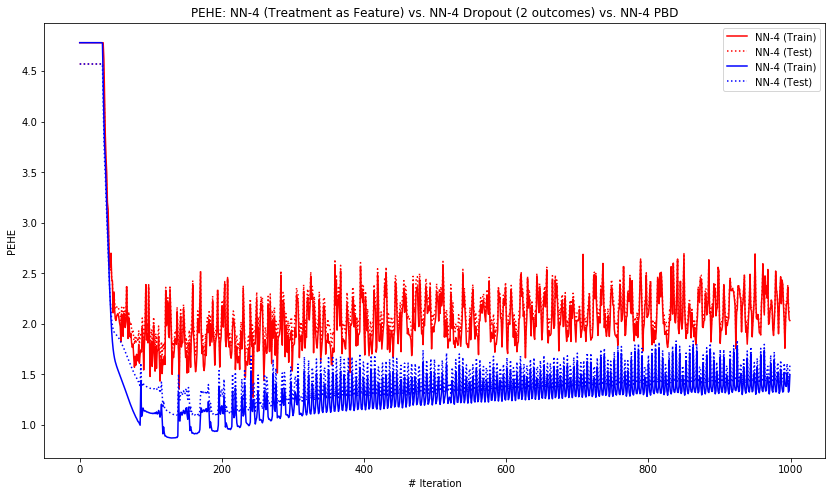

In [21]:
plt.title('PEHE: NN-4 (Treatment as Feature) vs. NN-4 Dropout (2 outcomes) vs. NN-4 PBD')
plt.plot(nn4_all_results[0]['pehe_train_vals'], label='NN-4 (Train)',  color='r')
plt.plot(nn4_all_results[0]['pehe_test_vals'], label='NN-4 (Test)',  color='r', linestyle=':')

plt.plot(nn4_no_dropout_all_results[0]['pehe_train_vals'], label='NN-4 (Train)',  color='b')
plt.plot(nn4_no_dropout_all_results[0]['pehe_test_vals'], label='NN-4 (Test)',  color='b', linestyle=':')
#plt.plot(nn4_all_pehe_train[4], label='NN-4 (Train) 2',  color='b')
#plt.plot(nn4_all_pehe_test[4], label='NN-4 (Test) 2',  color='b', linestyle=':')

#plt.plot(nn4_dropout_pehe_train, label='NN-4 Dropout (Train)',  color='b')
#plt.plot(nn4_dropout_pehe_test, label='NN-4 Dropout (Test)',  color='b', linestyle=':')
#plt.plot(nn4_pbd_pehe_train, label='NN-4 PBD (Train)',  color='g')
#plt.plot(nn4_pbd_pehe_test, label='NN-4 PBD (Test)',  color='g', linestyle=':')

plt.ylabel('PEHE')
plt.xlabel('# Iteration')
plt.legend(loc='upper right')
plt.show()

## Learning Curves

In [ ]:
#plt.title('NN-4 (Treatment as Feature)')
#plt.plot(nn4_mses_train, label='MSE (Train)')
#plt.ylabel('MSE')
#plt.xlabel('# Iteration')
#plt.legend(loc='upper right')
#plt.show()

#plt.title('NN-4 Dropout (2 outcomes)')
#plt.plot(nn4_dropout_mses_train_0, label='MSE Y0')
#plt.plot(nn4_dropout_mses_train_1, label='MSE Y1')
#plt.ylabel('MSE')
#plt.xlabel('# Iteration')
#plt.legend(loc='upper right')
#plt.show()

#plt.title('NN-4 PBD')
#plt.plot(nn4_pbd_mses_train_0, label='MSE Y0')
#plt.plot(nn4_pbd_mses_train_1, label='MSE Y1')
#plt.ylabel('MSE')
#plt.xlabel('# Iteration')
#plt.legend(loc='upper right')
#plt.show()